# Run 'stockread.py' once every weekday. 
## It may take up to an hour to download data 
## (depending on net speed)

In [5]:
import sys
#!python3 stockreader.py

# Import stockdatalib

In [6]:
import stockdatalib as sd
import ipywidgets as widgets

# Must set the data subdirectory

In [7]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')
sd.set_stocks_list_filename('screener_results.csv')

# Load Data and plot a stock

In [8]:
# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetStocksList()

In [10]:
# Set stock symbol
mystock = 'abc'
sd.set_stock(mystock)

In [11]:
#
stock_info = sd.get_stock_info(mystock)
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
print(stock_info)

{'stock': ['abc'], 'name': ['AmerisourceBergen Corp'], 'sector': ['Health Care']}


In [12]:
# Get latest price quote
print(sd.quote('abc'))

  symbol                date  close  volume
0    abc 2020-05-07 14:16:07  88.02  171499


In [13]:
# Get latest key stats on the stock
sd.key_stat(mystock)

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,abc,2019-12-31,206008000.0,4.786474e+10,229588000.0,96.427641,0.91,187640000.0,0.001577,1.231214e+09,0.366515


<Figure size 1080x432 with 0 Axes>

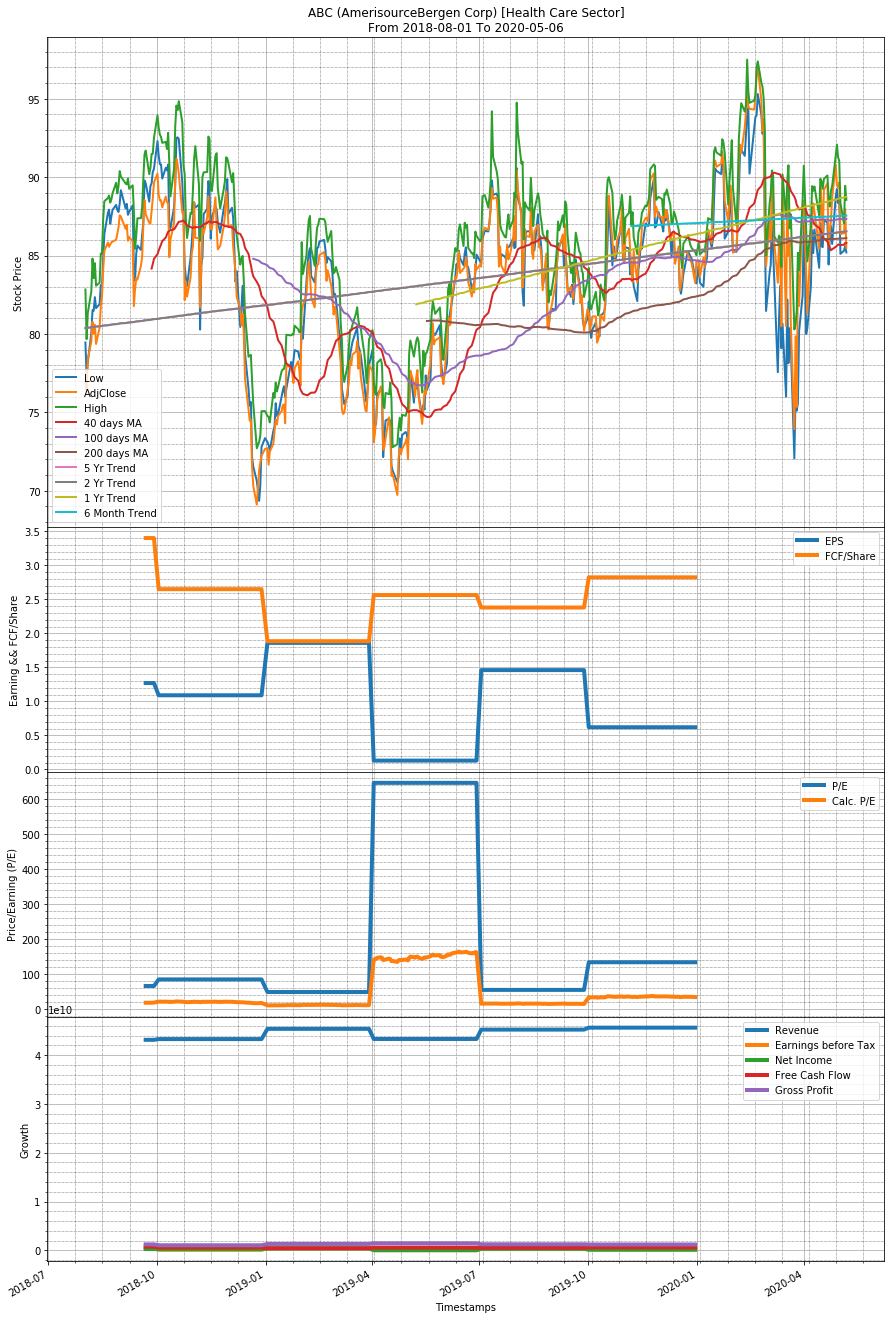

In [14]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2018-08-01') # limit the data since a specific past date or a range

linear_trends = sd.PlotBasicCharts(mystock,price_df)

In [15]:
# Linear Regression Equations returned by the plot call
linear_trends

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.01393 x + 80.38,0.01393 x + 80.38,0.02735 x + 81.89,0.00545 x + 86.87


In [17]:
# Get last price quote
sd.quote('abc')

,symbol,date,close,volume
0,abc,2020-05-07 14:16:07,88.02,171499


In [19]:
# Get last key stats on the stock
sd.quote('abc')

,symbol,date,close,volume
0,abc,2020-05-07 14:16:07,88.02,171499


<Figure size 1080x432 with 0 Axes>

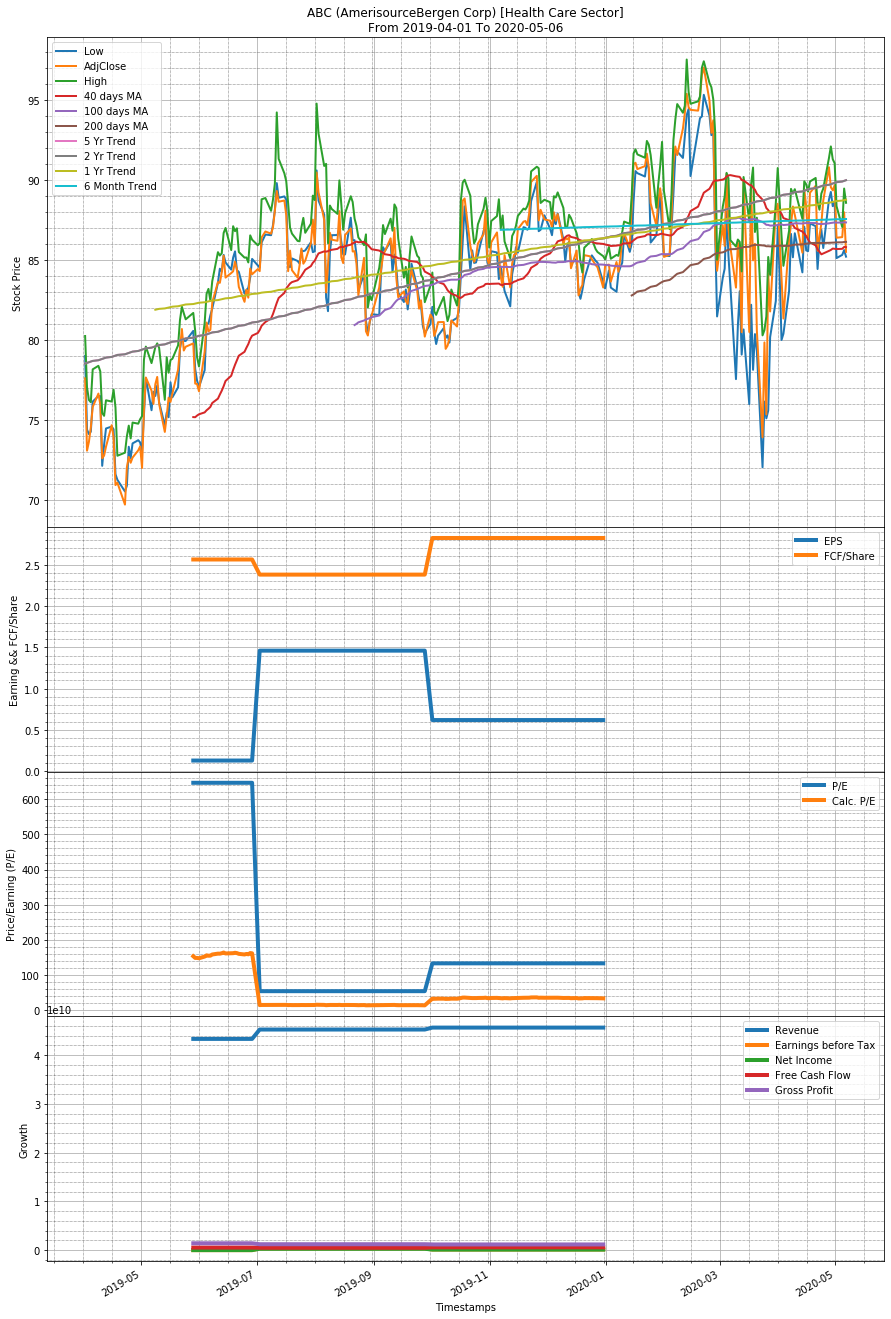

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.04129 x + 78.53,0.04129 x + 78.53,0.02735 x + 81.89,0.00545 x + 86.87


In [20]:
# Plot another stock
sd.set_stock('abc')
price_df = sd.GetStockDataFrame(sd.get_stock())
price_df_test = sd.DatesRange(price_df, '2019-04-01')
sd.PlotBasicCharts(sd.get_stock(),price_df_test)

In [21]:
sd.key_stat('abc')

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,abc,2019-12-31,206008000.0,4.786474e+10,229588000.0,96.427641,0.91,187640000.0,0.001577,1.231214e+09,0.366515


# The data load functions

In [22]:
# Load stock End of Day prices file
price_df = sd.GetStockDataFrame('abc')

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict('abc')

# Searching for data by column name

In [23]:
# Search for a key word in the data column names
table,text = sd.FindColumn('Weighted')
table

,column_name,DataFrame
0,Weighted Average Shs Out,income-statement
1,Weighted Average Shs Out (Dil),income-statement


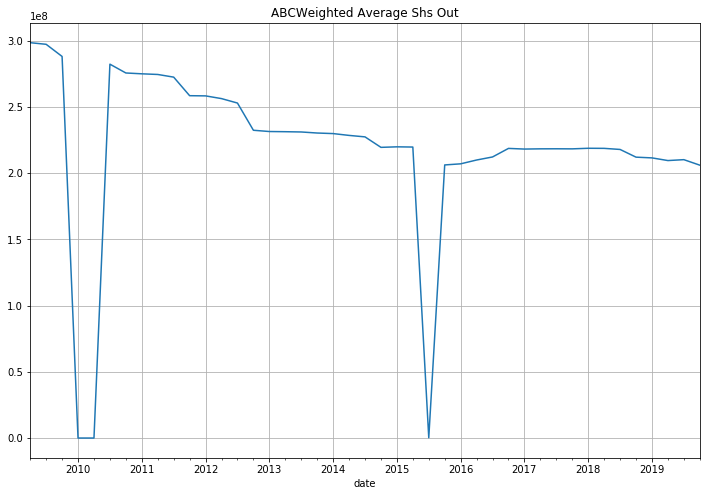

In [24]:
main_df_org['income-statement']['Weighted Average Shs Out'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+'Weighted Average Shs Out')
                                                                 

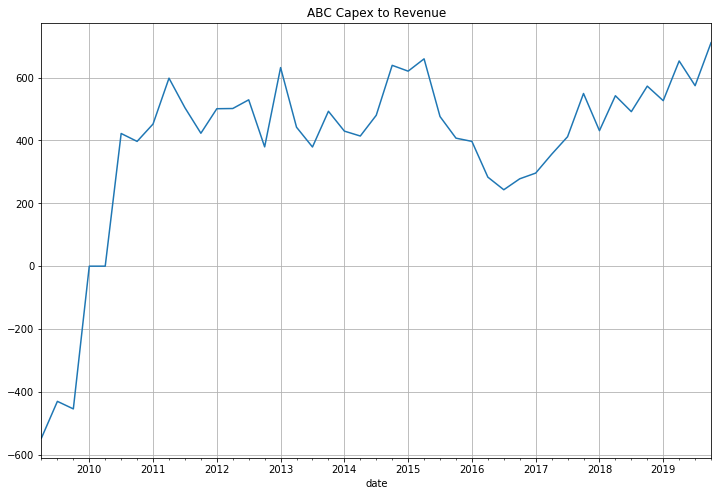

In [25]:
# Now we know where 'Capex to Revenue' is, we can load it from the DataFrame source 'company-key-metrics' as 
# the code below
main_df_org['company-key-metrics']['Capex to Revenue'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+' Capex to Revenue')

# Selecting data range from price data frame

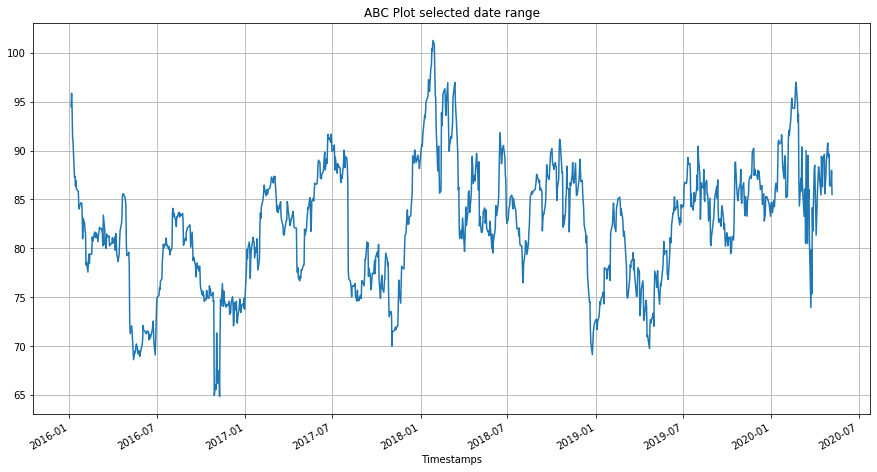

In [26]:
# Limit the stock prices data in the dates range
price_df = sd.DatesRange(price_df, '2016-01-01')

# Plot the prices chart
ax1 = price_df['AdjClose'].plot(figsize=(15,8),
                                title=sd.get_stock().upper()+" Plot selected date range").grid()

# Merging DataFrames from multiple sources into one DF

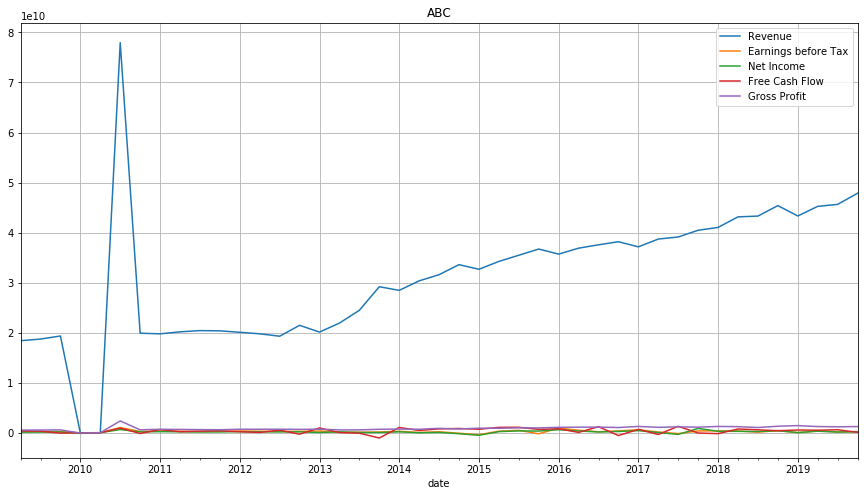

In [27]:
#
import pandas as pd

# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Create a 4th subject of columns from yet another fundamentals dataset
cols = ['Free Cash Flow per Share']
main_df4 = sd.MakeFund_Subset(main_df_org['company-key-metrics'],cols)


# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')
main_df = pd.merge(main_df,main_df4,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],
             figsize=(15,8),title=sd.get_stock().upper()).grid()


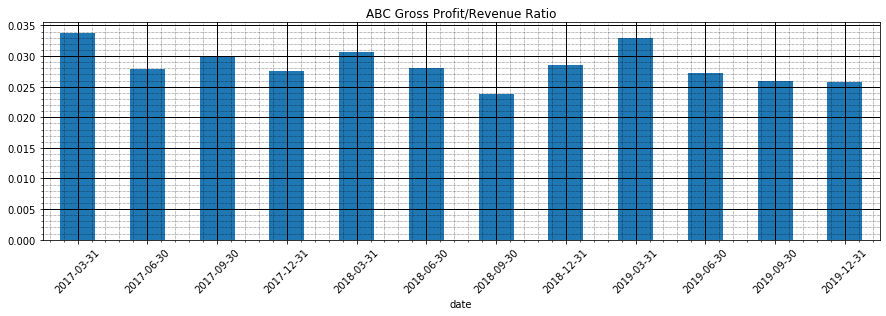

In [28]:
#
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

main_df = sd.DatesRange(main_df, '2017-01-01')
fig, ax = plt.subplots()
GrossOverRev_df = main_df['Gross Profit'] / main_df['Revenue']
ax = GrossOverRev_df.plot(ax=ax , kind='bar',
                          figsize=(15,4),
                          title=sd.get_stock().upper()+' Gross Profit/Revenue Ratio')

ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = GrossOverRev_df.index.strftime('%Y-%m-%d')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))


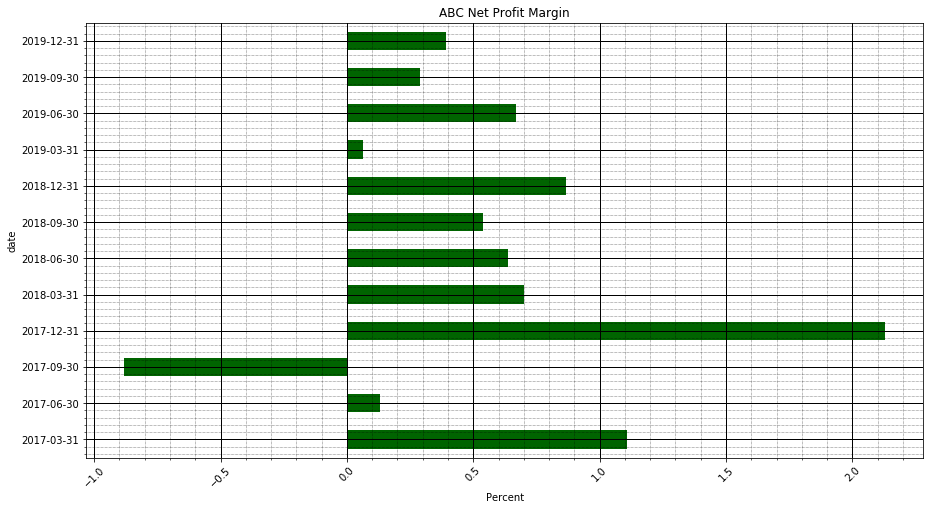

In [29]:
#
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
tmp_df = (main_df['Net Profit Margin'] * 100)
_=tmp_df.plot(ax=ax,y="Percent", kind='barh',figsize=(15,8),title=sd.get_stock().upper()+' Net Profit Margin',
              grid=True, color='darkgreen').set_xlabel('Percent')


ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = tmp_df.index.strftime('%Y-%m-%d')
ax.yaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

# Using DatesRange() on fundamental data 

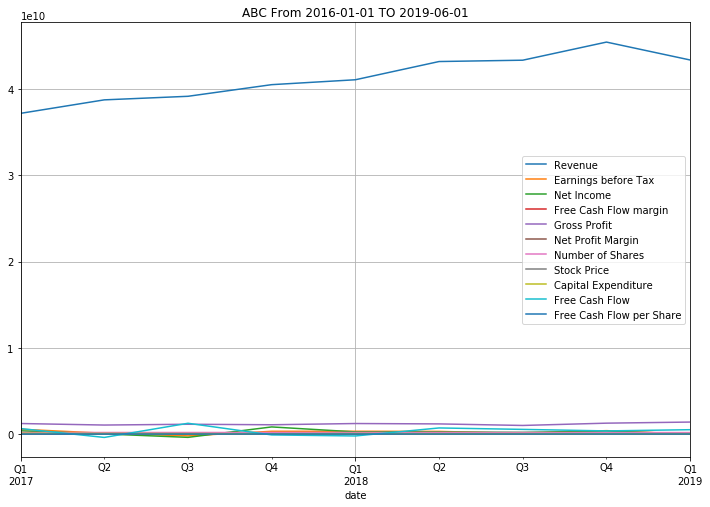

In [30]:
_=sd.DatesRange(main_df, '2016-01-01', '2019-06-01').plot(figsize=(12,8),
                                                                     grid=True,
                                                                     title=sd.get_stock().upper()+' From 2016-01-01 TO 2019-06-01')

<Figure size 1080x432 with 0 Axes>

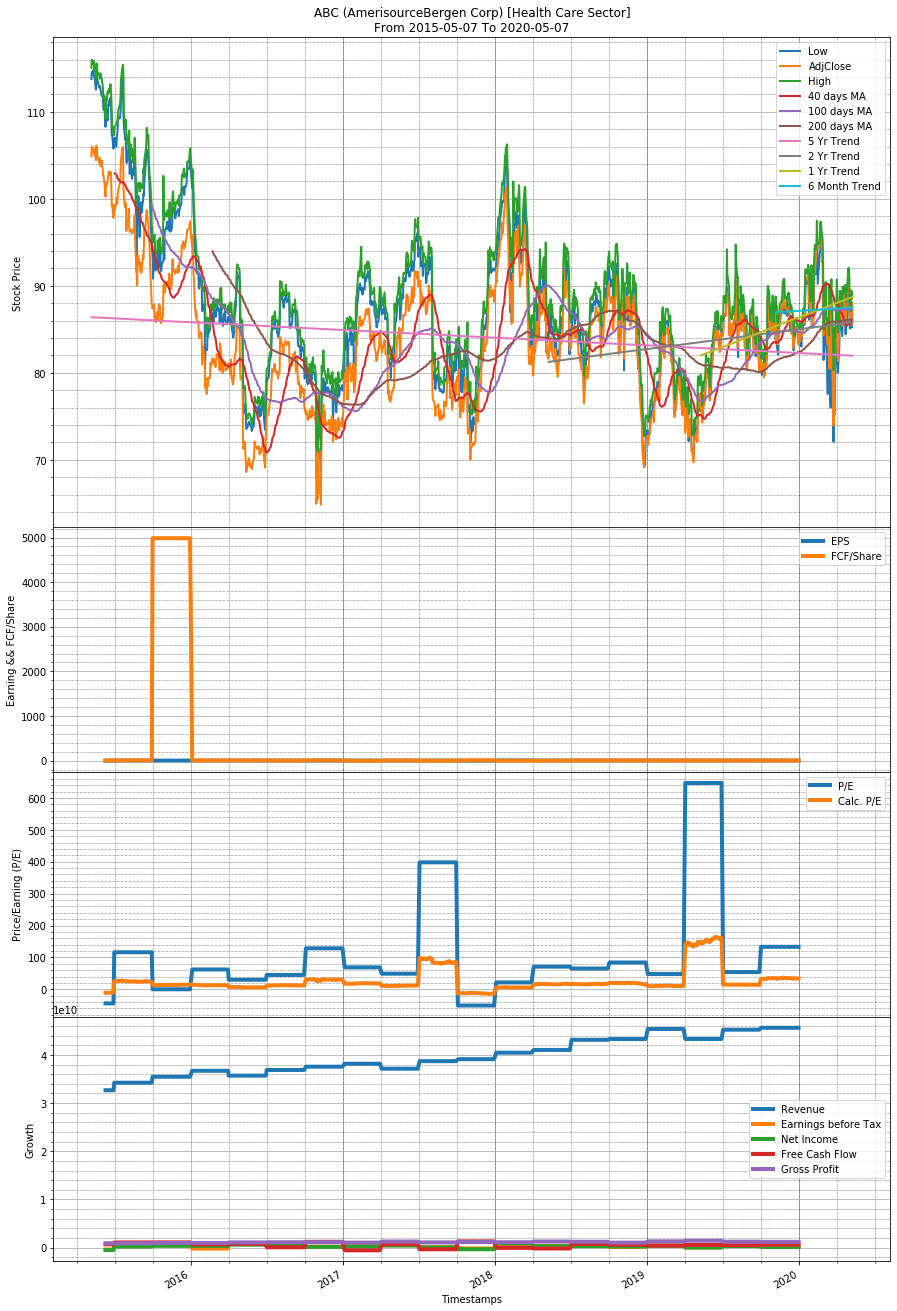

In [31]:
# Plot price chart with trend lines, EPS, and PE ratios
_=sd.PlotBasicCharts('ABC')

# Plot a single key stat item

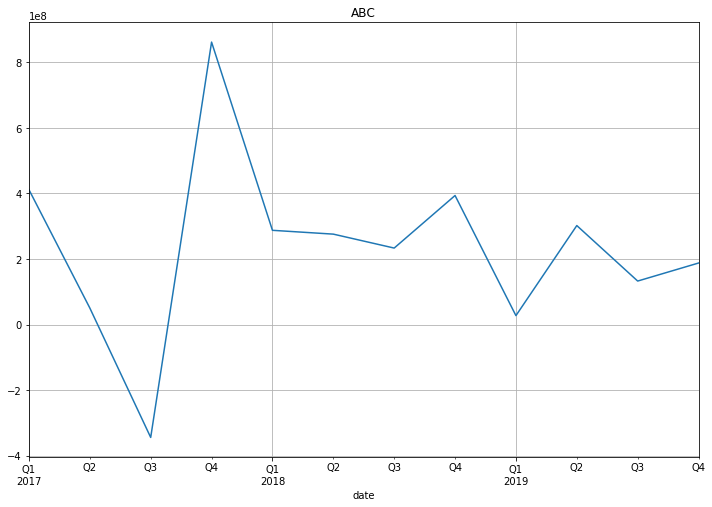

In [32]:
main_df['Net Income'].plot(figsize=(12,8), title = sd.get_stock().upper()).grid()

# Plot the TrendChart()

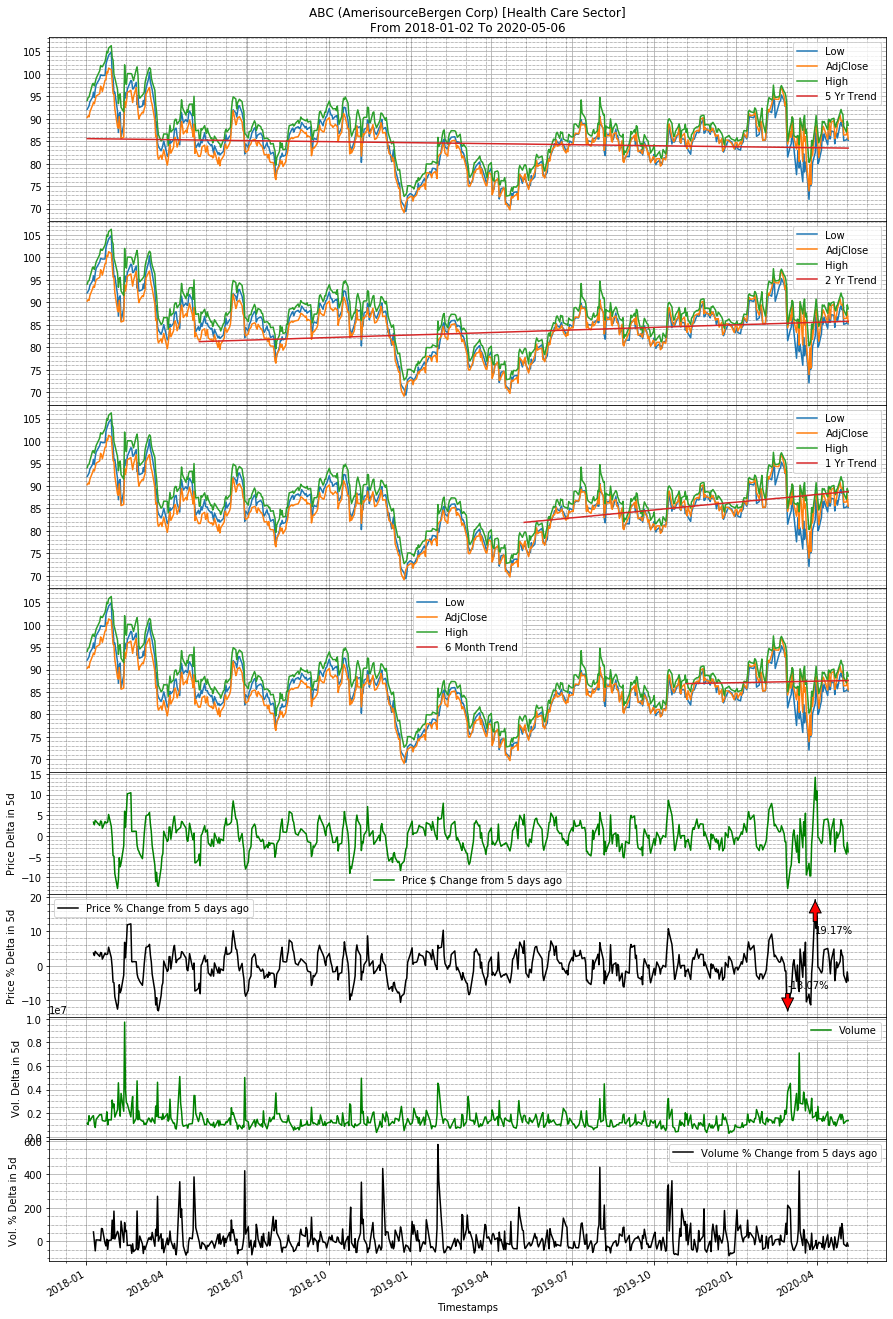

In [34]:
price_df = sd.GetStockDataFrame('abc')
price_df = sd.DatesRange(price_df, '2018-01-01')
price_data_df, maximums_table_df = sd.PlotTrends('abc',price_df)

# Show the Maximums Table in price and volume

In [35]:
maximums_table_df

,Date,Price,Volume
Change Type,,,
Max % Rise,2020-03-30,19.17%,--
Max % Drop,2020-02-28,-13.07%,--
Max % Rise,2019-01-31,--,577.94%
Max % Drop,2019-12-24,--,-85.45%


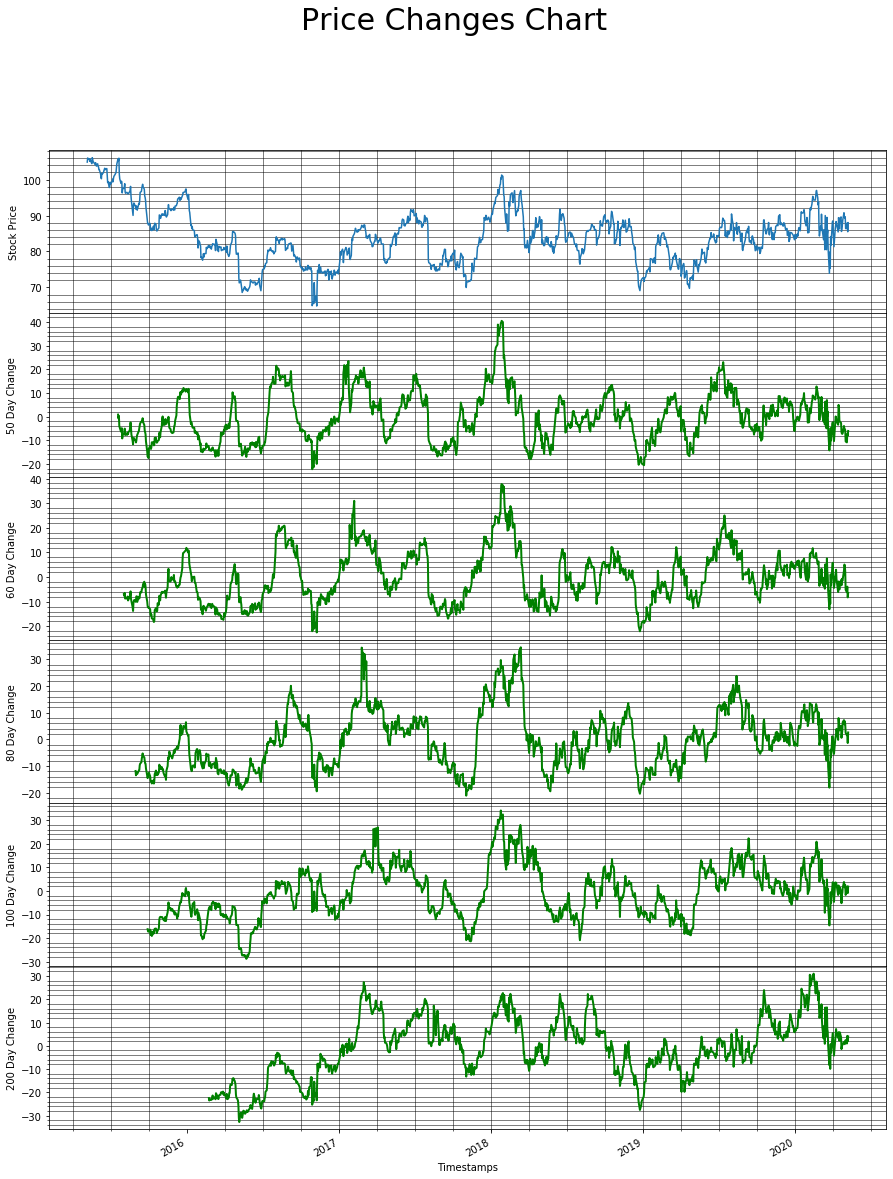

In [36]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame('abc')

# You can limit the range if needed
#price_df = sd.DatesRange(price_df, '2016-02-01')
   
sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

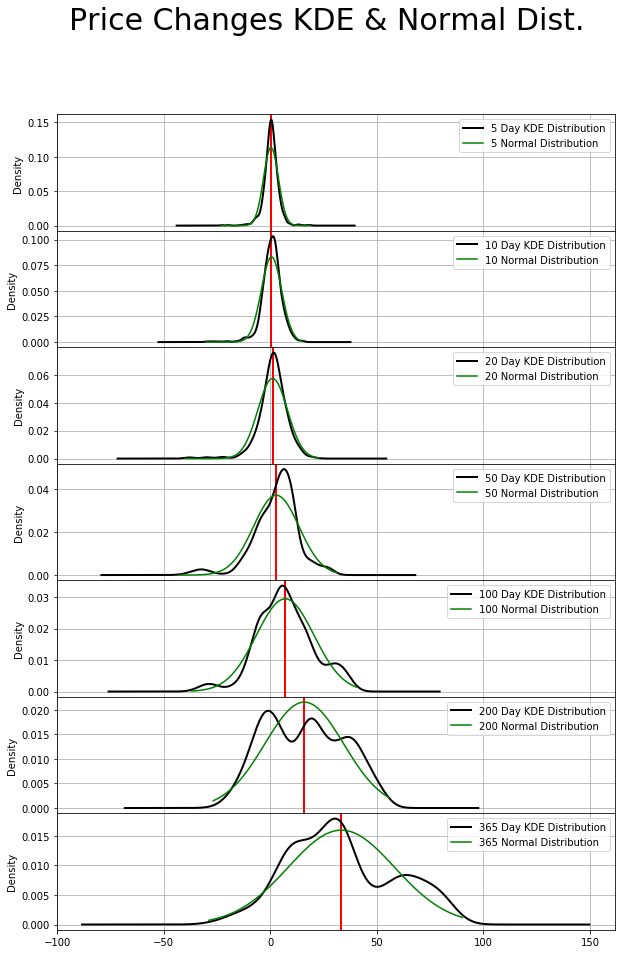

,Record Count,Mean of % Price Change,Std. Dev of % Price Change,Var of % Price Change,Max. % Price Rise,Max % Price Drop
index,,,,,,
5,1255.0,0.276118,3.508503,12.309593,18.646809,-23.107305
10,1250.0,0.519091,4.801914,23.058381,15.064526,-30.004170
20,1240.0,1.048793,6.948259,48.278305,22.874846,-40.201275
50,1210.0,2.745836,10.702771,114.549308,31.167480,-42.498546
100,1160.0,6.946643,13.562278,183.935383,40.594640,-37.129590
200,1060.0,15.896208,18.492241,341.962983,56.111224,-26.844153
365,895.0,33.324887,24.967224,623.362254,90.198710,-28.875599


In [37]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame('jpm')
price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
stats

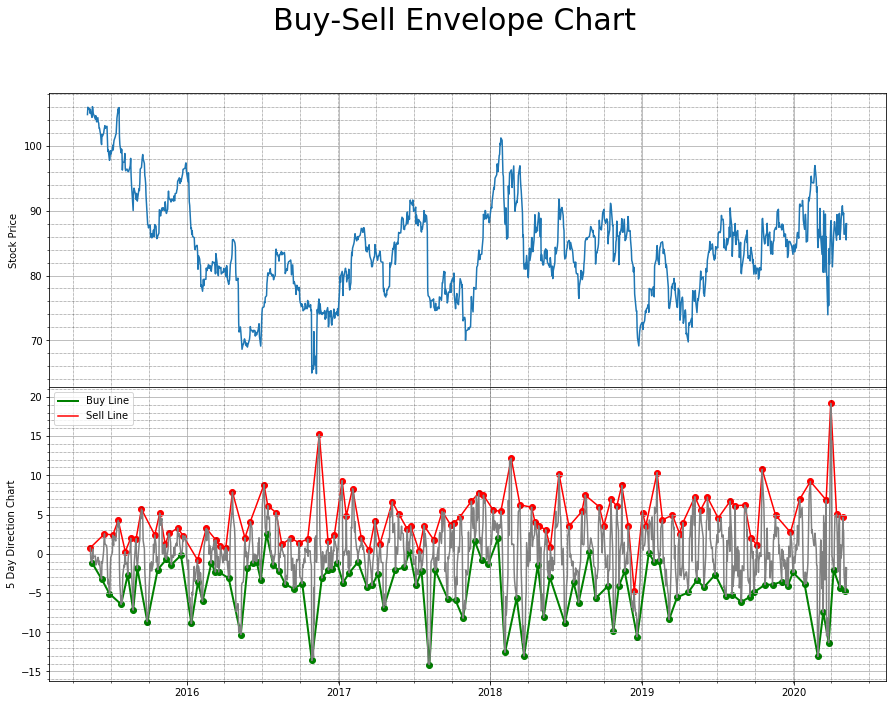

In [38]:
price_df = sd.GetStockDataFrame('abc')
sd.PlotBuySellEnvelope(price_df, 5)


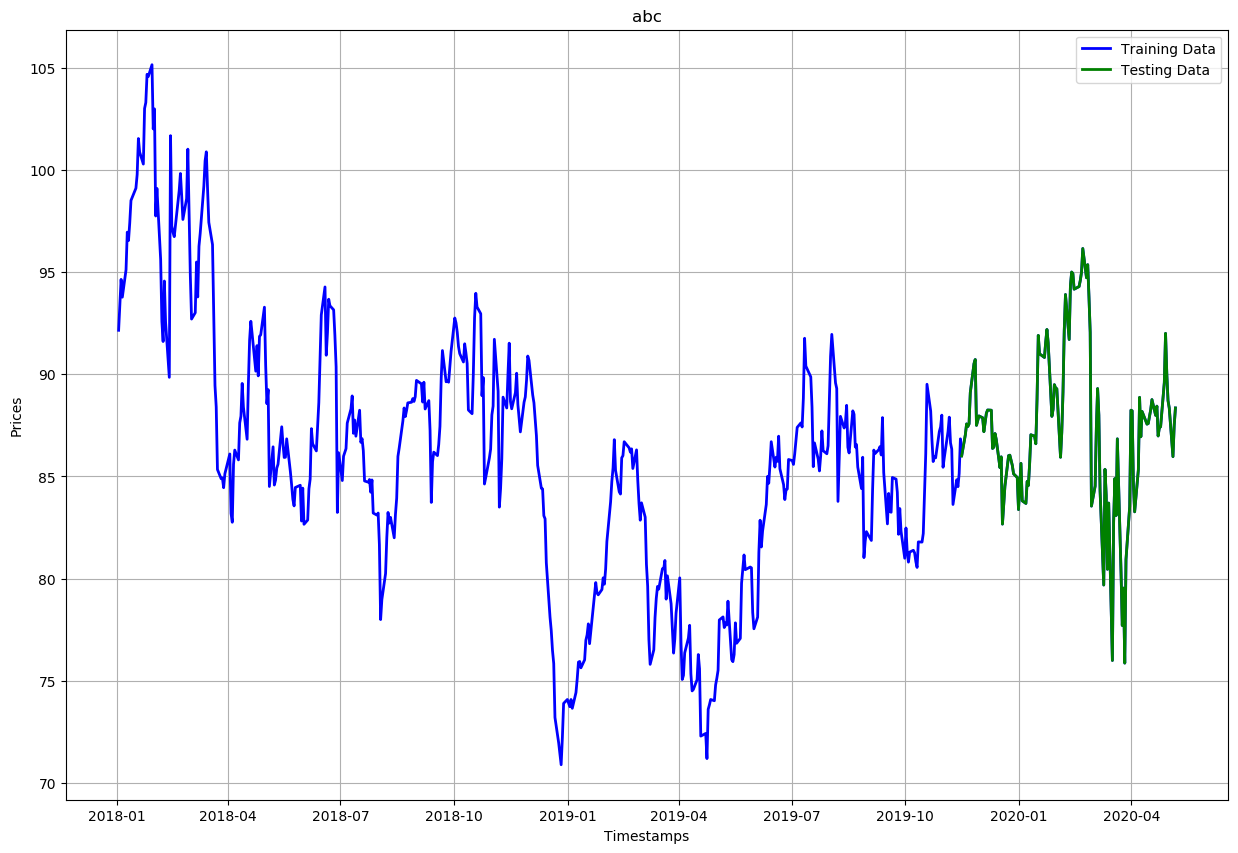

In [39]:
#
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas.plotting as pdplt
#from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('default')

sd.set_stock('abc')
price_df = sd.GetStockDataFrame(sd.get_stock())
price_df = sd.DatesRange(price_df, '2018-01-01')
df = price_df.copy(deep=True)

#split price dataframe into Training set and Test set, 80% to 20%
train_data = df[0:int(len(df)*0.8)].copy()
test_data  = df[int(len(df)*0.8):].copy()

plt.figure(figsize=(15,10))
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
plt.plot(df['Open'], 'blue', label='Training Data',lw=2.0)
plt.plot(test_data['Open'], 'green', label='Testing Data',lw=2.0)
#plt.xticks(np.arange(0,7982, 1300), df['Timestamps'][0:7982:1300])
plt.legend()
plt.grid()

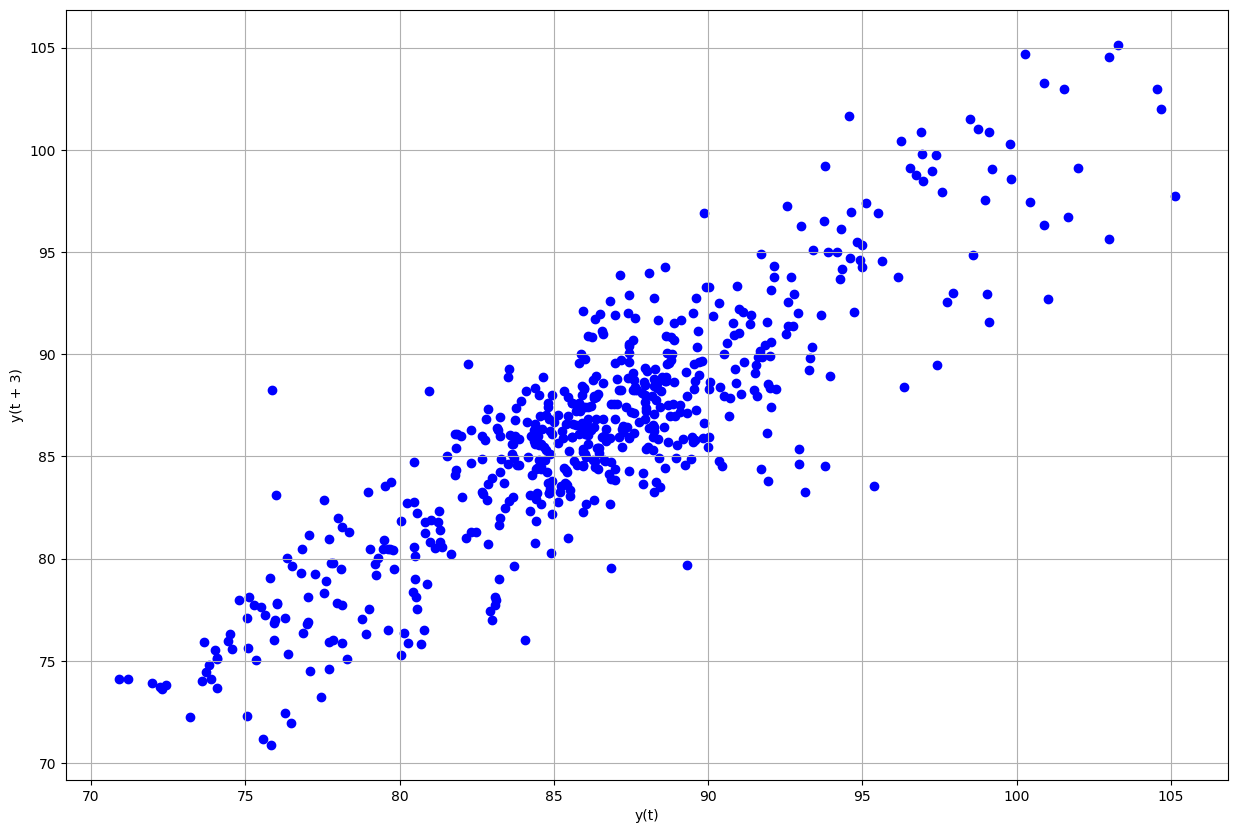

In [40]:

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

plt.figure(figsize=(15,10))
plt.grid()
pdplt.lag_plot(df['Open'], lag=3,c='b')

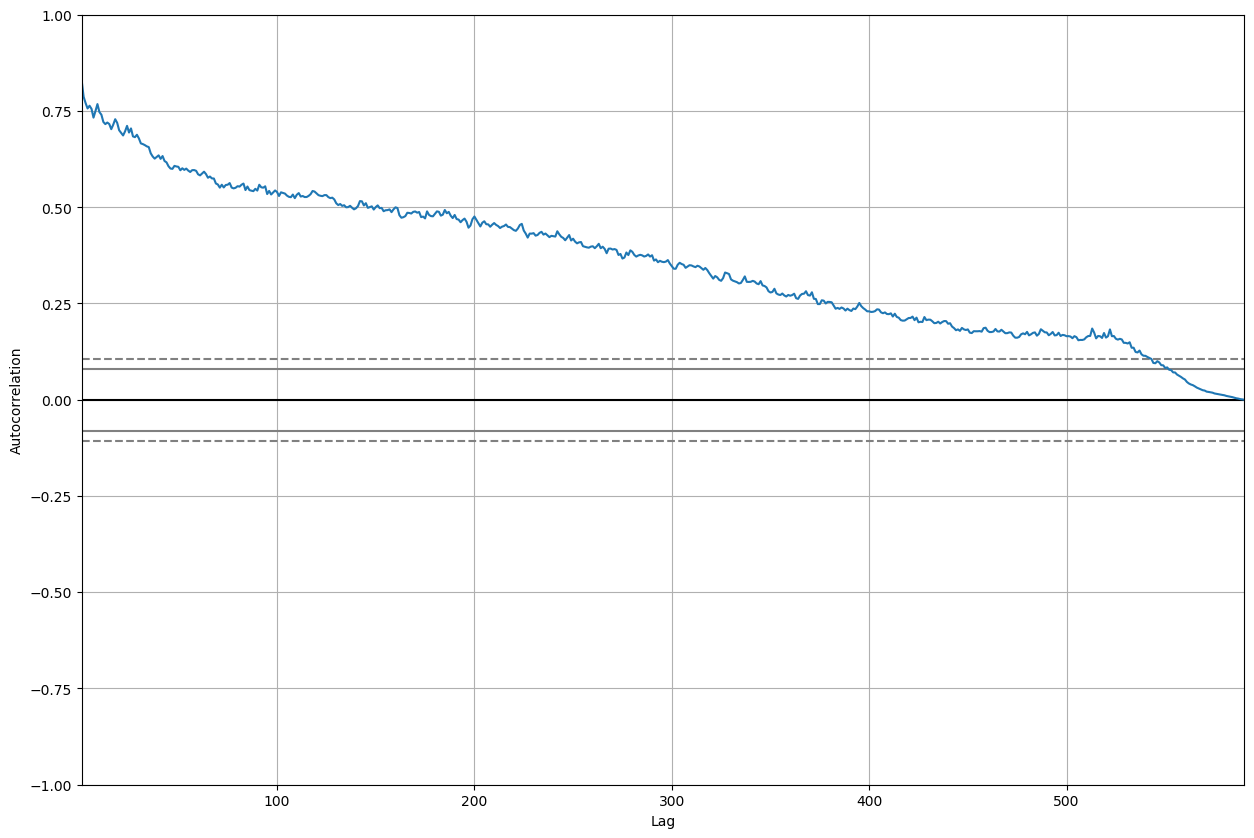

In [41]:

plt.figure(figsize=(15,10))
pdplt.autocorrelation_plot(df)


In [42]:
#
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values
history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

def PredictNextPrice():
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    return yhat[0]

Testing Mean Squared Error: 8.931
Symmetric mean absolute percentage error: 5.464


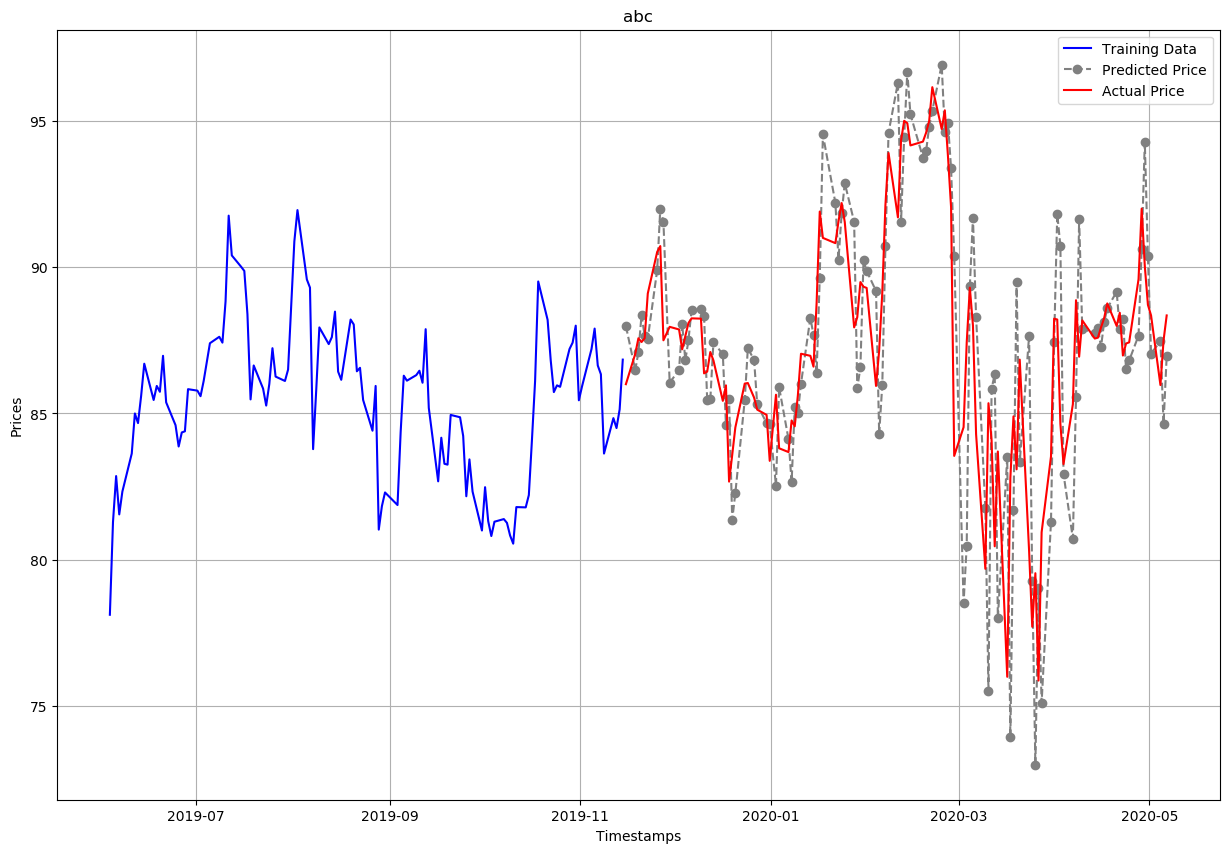

In [43]:
#
plt.figure(figsize=(15,10))

#Resize the data
train_data['Open'] = sd.DatesRange(train_data['Open'], '2019-06-01')
test_data['Open'] = sd.DatesRange(test_data['Open'], '2019-06-01')

plt.plot(train_data['Open'], 'red', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='gray', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()
plt.grid()

In [44]:
print(sd.quote(sd.get_stock()).close[0])
next_price = PredictNextPrice()
print(next_price)

88.02
89.55679834560125


# Search for a column containing 'cash flow' substring

In [45]:
f,s = sd.FindColumn('cash flow')
f

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Operating Cash Flow,cash-flow-statement
2,Investing Cash flow,cash-flow-statement
3,Financing Cash Flow,cash-flow-statement
4,Net cash flow / Change in cash,cash-flow-statement
5,Free Cash Flow,cash-flow-statement
6,Operating Cash Flow per Share,company-key-metrics
7,Free Cash Flow per Share,company-key-metrics
8,EV to Operating cash flow,company-key-metrics
9,EV to Free cash flow,company-key-metrics


In [46]:
fcfy_df = main_df_org['company-key-metrics']['Free Cash Flow Yield']

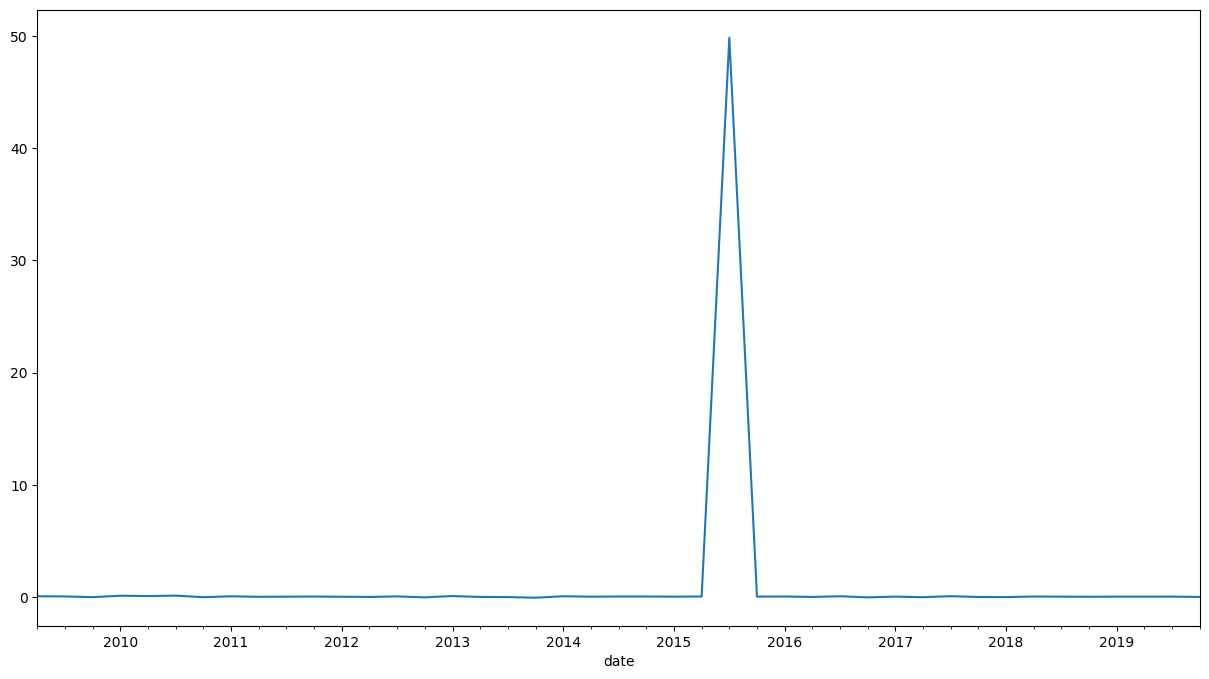

In [47]:
fcfy_df.plot(figsize=(15,8))

In [51]:
import time
def print_over(txt):
    print('\r',end='')
    print(txt,end='')
    
r,c,stocks = sd.GetStocksList()
for s in stocks['Symbol']:
    print_over(s)
    time.sleep(0.1)
    


ZYXIF

In [60]:
r,c,stocks = sd.GetStocksList()
stocks
for s in stocks['Symbol']:
    print_over(s)

ZTSNL

In [61]:
import sys
import inspect
current_module = sys.modules[__name__]

def print_classes(mod):
    for name, obj in inspect.getmembers(sys.modules[mod]):
        if inspect.isclass(obj):
            print(name,obj)

print_classes('matplotlib')           

#inspect.getmembers(sys.modules['matplotlib'])
#dir(matplotlib.pyplot)

LooseVersion <class 'distutils.version.LooseVersion'>
MatplotlibDeprecationWarning <class 'matplotlib.cbook.deprecation.MatplotlibDeprecationWarning'>
MutableMapping <class 'collections.abc.MutableMapping'>
Parameter <class 'inspect.Parameter'>
Path <class 'pathlib.Path'>
RcParams <class 'matplotlib.RcParams'>
_ExecInfo <class 'matplotlib._ExecInfo'>
mplDeprecation <class 'matplotlib.cbook.deprecation.MatplotlibDeprecationWarning'>
rc_context <class 'matplotlib.rc_context'>


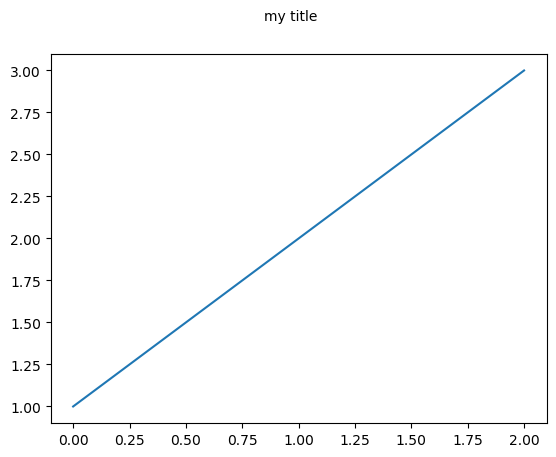

In [62]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


class MyFigure(Figure):
    def __init__(self, *args, figtitle='hi mom', **kwargs):
        """
        custom kwarg figtitle is a figure title
        """
        super().__init__(*args, **kwargs)
        self.text(0.5, 0.95, figtitle, ha='center')


fig = plt.figure(FigureClass=MyFigure, figtitle='my title')
ax = fig.subplots()
ax.plot([1, 2, 3])

plt.show()

In [63]:
class Animal:
    def __init__(self, Name=", Age=0, Type="):
        self.Name = Name
        self.Age = Age
        self.Type = Type
    def GetName(self):
        return self.Name
    def SetName(self, Name):
        self.Name = Name
    def GetAge(self):
        return self.Age
    def SetAge(self, Age):
        self.Age = Age
    def GetType(self):
        return self.Type
    def SetType(self, Type):
        self.Type = Type
    def __str__(self):
        return "{0} is a {1} aged {2}".format(self.Name,self.Type,self.Age)
    
class Chicken(Animal):
    def __init__(self, Name='', Age=0):
        self.Name = Name
        self.Age = Age
        self.Type = "Chicken"
    def SetType(self, Type):
        print("Sorry, {0} will always be a {1}".format(self.Name, self.Type))
    def MakeSound(self):
        print("{0} says Cluck, Cluck, Cluck!".format(self.Name))

In [64]:
an = Chicken()
an.SetType('banana')

Sorry,  will always be a Chicken


In [65]:
import matplotlib.pyplot as plt
from matplotlib import pyplot


class MyPlot(plt):
    def __init__(self):
        super().__init__()
        self.plot([(1,2)])


fig = plt.plot(figtitle='my title')
ax = fig.subplots()
ax.plot([1, 2, 3])

plt.show()

TypeError: module() takes at most 2 arguments (3 given)